In [1]:
# allow the notebook to access the parent directory so we can import the other modules
# https://stackoverflow.com/a/35273613
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

# Data Preparation
-----

### Constants and Folder Paths

In [2]:
import os
dataset_folder_path = os.path.join("..", "files", "dataset")

In [3]:
from data.DataSet import DataSet
dataset = DataSet()
dataset.load(dataset_folder_path, test_set_percentage=0.2, validation_set_percentage=0.3333)

print("Training Data Len:", len(dataset.train_data))
print("Validation Data Len:", len(dataset.valid_data))
print("Test Data Len:", len(dataset.test_data))

36 files found!
Training Data Len: 1900
Validation Data Len: 1000
Test Data Len: 700


### Data Preprocessing

In [4]:
NUM_SAMPLES = 50
ANGLES_TO_ROTATE = [5, 10, 15, 45, -5, -10, -15, -45]

In [5]:
from utils.preprocessing import *
from functools import partial
dataset.apply(apply_mean_centering)
dataset.apply(apply_unit_distance_normalization)
dataset.apply(partial(spline_interpolate_and_resample, num_samples=NUM_SAMPLES))
dataset.expand_many(partial(rotate_digit, degrees=ANGLES_TO_ROTATE))
dataset.expand(reverse_digit_sequence)

print("Training Data Len:", len(dataset.train_data))
print("Validation Data Len:", len(dataset.valid_data))
print("Test Data Len:", len(dataset.test_data))

Training Data Len: 34200
Validation Data Len: 18000
Test Data Len: 12600


### Split Dataset into *Train*, *Valid*, and *Test*

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train = np.array(dataset.train_data)
X_valid = np.array(dataset.valid_data)
X_test = np.array(dataset.test_data)

# Convert labels to numpy array and OneHot encode them
encoder, Y_train, Y_valid, Y_test = dataset.onehot_encode_labels()

print("Training Data Shape:", X_train.shape)
print("Training Labels Shape:", Y_train.shape)
print("Validation Data Shape:", X_valid.shape)
print("Validation Labels Shape:", Y_valid.shape)
print("Test Data Shape:", X_test.shape)
print("Test Labels Shape:", Y_test.shape)

Training Data Shape: (34200, 50, 2)
Training Labels Shape: (34200, 10)
Validation Data Shape: (18000, 50, 2)
Validation Labels Shape: (18000, 10)
Test Data Shape: (12600, 50, 2)
Test Labels Shape: (12600, 10)


----------
# Neural Network Setup and Training
----------

## **Regularized 3x512 GRU**

### Parameters

In [7]:
PARAM_NUM_EPOCHS = 20
PARAM_BATCH_SIZE = 500

### Setup Model

In [9]:
from models.regularized_3x512_gru import Regularized3x512GRU
import os.path

mymodel = Regularized3x512GRU(X_train.shape[1:], output_path=os.path.join("..", "files"))
mymodel.batch_size = PARAM_BATCH_SIZE
mymodel.num_epochs = PARAM_NUM_EPOCHS
mymodel.initialize()
print(mymodel)



----------

Optimizer: <class 'keras.optimizers.Nadam'>
Batch Size: 500
Number of Epochs: 20

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 50, 512)           791040    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 512)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 50, 512)           1575936   
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 512)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 512)               1575936   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
______________________________________________

#### Save Model Summary

In [ ]:
mymodel.save_summary(dataset.get_recorded_operations())
mymodel.save_config()

### Train Model

In [ ]:
mymodel.train(X_train, Y_train, X_valid, Y_valid)

### Evaluate Model

#### Test Set Accuracy

In [11]:
test_score = tuple(mymodel.model.evaluate(X_test, Y_test))
print("Test Loss: %.3f, Test Acc: %.3f%%" % (test_score[0], test_score[1] * 100))

12600/12600 [==============================] - 10s 758us/step
Test Loss: 0.109, Test Acc: 97.857%


#### Recall, Precision, F1_Score on Validation set

In [12]:
from utils.evaluation import get_evaluation_metrics, get_confusion_matrix

Y_predicted_valid = mymodel.model.predict_classes(X_valid, verbose=1)
rpf_valid = get_evaluation_metrics(Y_valid, Y_predicted_valid)
rpf_valid

18000/18000 [==============================] - 13s 727us/step


,recall,precision,f1 score,#
0,0.987243,0.988889,0.988066,1800.0
1,0.991912,0.953889,0.972529,1800.0
2,0.983680,0.971111,0.977355,1800.0
3,0.981997,1.000000,0.990917,1800.0
4,0.965312,0.989444,0.977229,1800.0
5,0.995362,0.953889,0.974184,1800.0
6,0.988950,0.994444,0.991690,1800.0
7,0.932248,0.986111,0.958423,1800.0
8,0.985091,0.991111,0.988092,1800.0
9,0.979557,0.958333,0.968829,1800.0


Average F1 Score for Validation Set

In [13]:
rpf_valid.mean()

recall          0.979135
precision       0.978722
f1 score        0.978731
#            1800.000000
dtype: float64

#### Recall, Precision, F1_Score on Test set

In [14]:
from utils.evaluation import get_evaluation_metrics, get_confusion_matrix

Y_predicted_test = mymodel.model.predict_classes(X_test, verbose=1)
rpf_test = get_evaluation_metrics(Y_test, Y_predicted_test)
rpf_test

12600/12600 [==============================] - 9s 719us/step


,recall,precision,f1 score,#
0,0.988255,0.934921,0.960848,1260.0
1,0.943009,0.984921,0.963509,1260.0
2,0.974379,0.996032,0.985086,1260.0
3,0.998381,0.978571,0.988377,1260.0
4,0.978005,0.988095,0.983024,1260.0
5,0.996732,0.968254,0.982287,1260.0
6,0.986443,0.981746,0.984089,1260.0
7,0.977795,0.978571,0.978183,1260.0
8,0.977866,0.981746,0.979802,1260.0
9,0.968266,0.992857,0.980408,1260.0


Average F1 Score for Test Set

In [15]:
rpf_test.mean()

recall          0.978913
precision       0.978571
f1 score        0.978561
#            1260.000000
dtype: float64

##### Increase default plotsize for matplotlib

In [16]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

#### Plot Validation Set Confusion Matrix

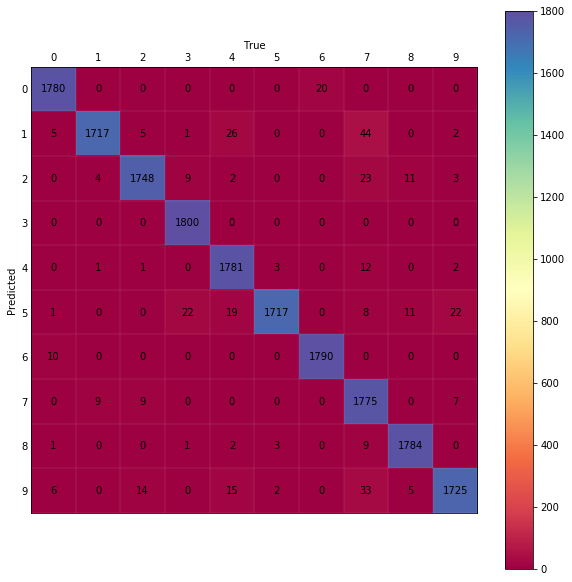

In [17]:
from utils.evaluation import get_confusion_matrix
# Confusion Matrix
confmat = get_confusion_matrix(Y_valid, Y_predicted_valid, plot=True)

#### Plot Test Set Confusion Matrix

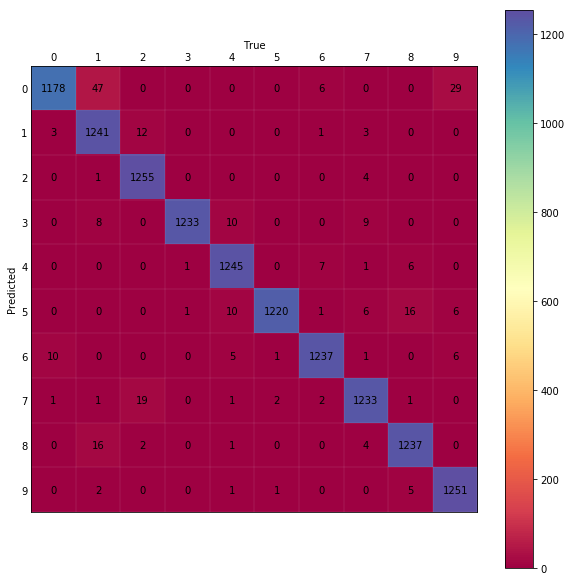

In [18]:
from utils.evaluation import get_confusion_matrix
# Confusion Matrix
confmat = get_confusion_matrix(Y_test, Y_predicted_test, plot=True)

# Backup Code
-----

In [10]:
from keras.models import load_model
mymodel.model = load_model("../files/checkpoints/1525696834.4091375/unregularized_512_gru-30-0.97.hdf5")